### 权重衰减（weight decay）:
    解决过拟合问题的常用方法

#### 方法:
    权重衰减等价于 L2 范数正则化（regularization）,即正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小
    
    L2 范数正则化在模型原损失函数基础上添加 L2 范数惩罚项，从而得到训练所需要最小化的函数
![L2loss_1](./img/3.8/L2loss_1.png)
![L2loss_2](./img/3.8/L2loss_2.png)

#### 高维线性回归实验:
    引入一个过拟合问题，并使用权重衰减来应对过拟合
![ep_1](./img/3.8/ep_1.png)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys

In [23]:
n_train,n_test,num_inputs = 20,100,200
true_w,true_b = torch.ones((num_inputs,1)) * 0.01,0.05

features = torch.randn((n_train + n_test,num_inputs))
labels = torch.mm(features,true_w) + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]

In [24]:
# 初始化模型参数
def init_params():
    w = torch.randn((num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

#### 定义 L2 范数惩罚项

In [25]:
def l2_penalty(lambd,w):
    return lambd * (w ** 2).sum() / 2

In [26]:
def linreg(x,w,b):
    return x @ w + b

In [27]:
def squared_loss(y_hat,y):
    return (y_hat - y.view(-1,1)) ** 2 / 2

In [28]:
# 定义训练和测试
batch_size,num_epochs,lr = 1,100,0.003
net,loss_fn = linreg,squared_loss

dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

In [29]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(20,8)):
    plt.figure(figsize=figsize,dpi=80)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [30]:
def fit_and_plot(lambd):
    w,b = init_params()
    params = [w,b]
    train_loss,test_loss = [],[]
    for _ in range(num_epochs):
        for x,y in train_iter:
            y_hat = net(x,w,b)
            loss = loss_fn(y_hat,y) + l2_penalty(lambd,w) # 添加了L2范数惩罚项
            loss = loss.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            loss.backward()
            
            if params is not None:
                for param in params:
                    param.data -= param.grad * lr / batch_size
        
        train_loss.append(loss_fn(net(train_features,w,b),train_labels).mean().item())
        test_loss.append(loss_fn(net(test_features,w,b),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_loss,'epoch','loss',
            range(1,num_epochs+1),test_loss,['train','test'])
    print('L2 norm of w:', w.norm().item())

#### 观察过拟合

L2 norm of w: 13.026556015014648


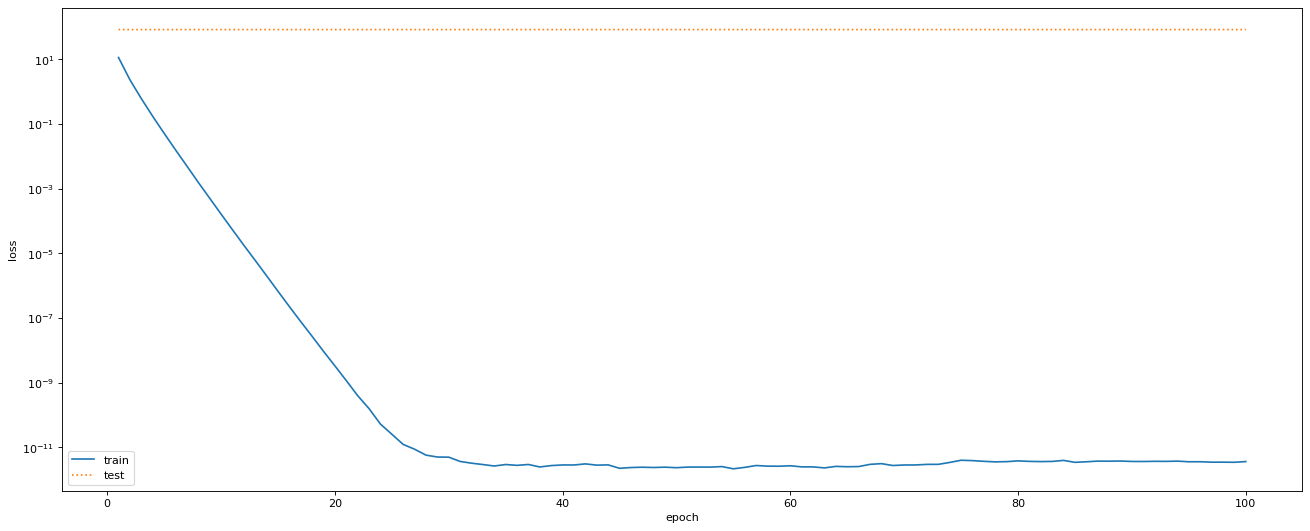

In [31]:
fit_and_plot(0)

#### 使用权重衰减

L2 norm of w: 0.029524633660912514


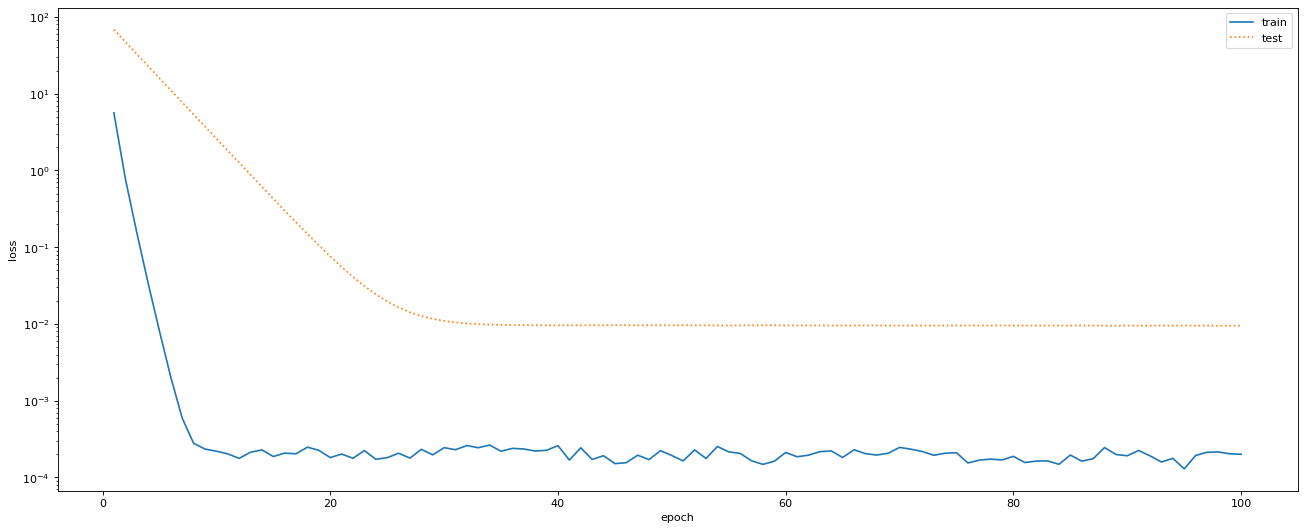

In [32]:
fit_and_plot(lambd=3)

### 简洁实现 权重衰减
    通过优化器中的 weight_decay 参数来指定权重衰减超参数

In [34]:
train_features.shape

torch.Size([20, 200])

In [36]:
def fit_and_plot(wd):
    net = torch.nn.Linear(train_features.shape[-1],1)
    torch.nn.init.normal_(net.weight,mean=0,std=1)
    torch.nn.init.normal_(net.bias,mean=0,std=1)
    
    optimizer_w = torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd) # 通过weight_decay参数来指定权重衰减超参数
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr)
    
    train_loss,test_loss =[],[]
    for _ in range(num_epochs):
        for x,y in train_iter:
            y_hat = net(x)
            loss = loss_fn(y_hat,y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            loss.backward()
            optimizer_w.step()
            optimizer_b.step()
            
        train_loss.append(loss_fn(net(train_features),train_labels).mean().item())
        test_loss.append(loss_fn(net(test_features),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_loss,'epoch','loss',
            range(1,num_epochs+1),test_loss,['train','test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 14.841931343078613


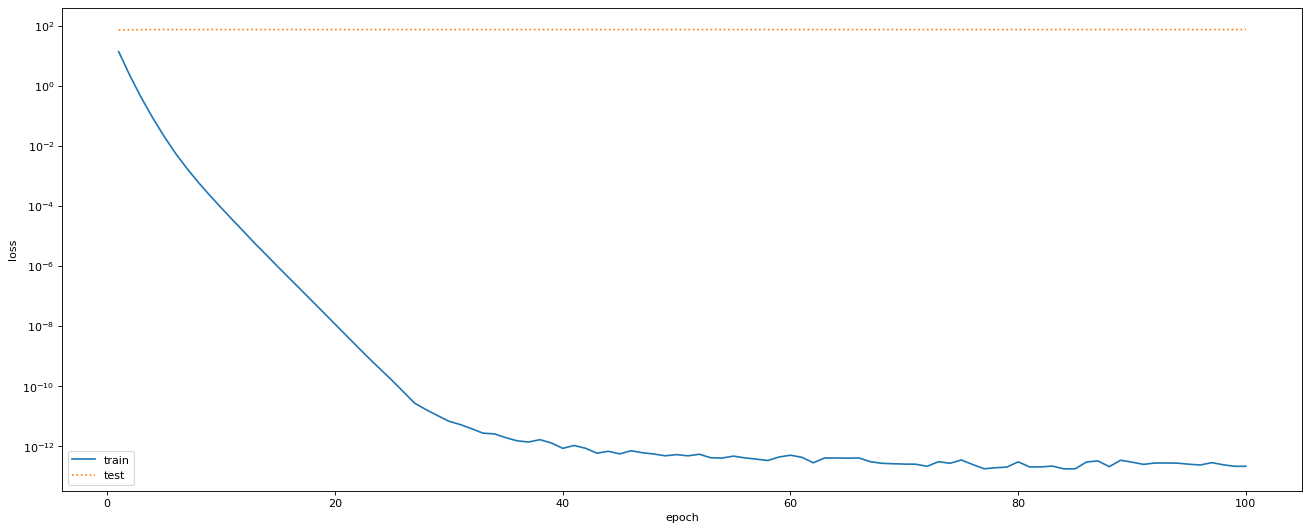

In [37]:
fit_and_plot(0)

L2 norm of w: 0.049566276371479034


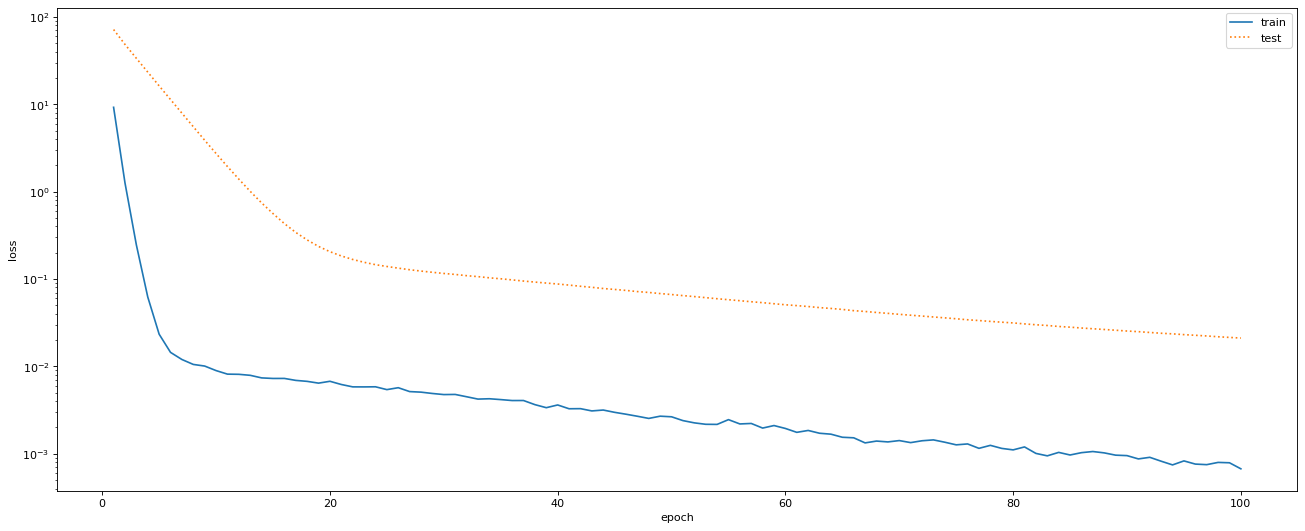

In [38]:
fit_and_plot(3)